<a href="https://colab.research.google.com/github/INA-95/beer_data_analysis/blob/main/beer_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# library

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from seaborn import heatmap

import nltk
nltk.download('all')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [3]:
# import Dataset

file_path = '/content/drive/MyDrive/Side Project/Side_Project/Beer Data Analysis/datasets/datasets/BeerDataScienceProject.tar.bz2'
df = pd.read_csv(file_path, compression = "bz2")
df.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206



### 1.Rank the top 3 breweries which produce the strongest beers

In [4]:
# top 3 breweries by ABV

def top_n_breweries_by_ABS(n:int):
    breweries_and_ABV = df[['beer_ABV', 'beer_beerId', 'beer_brewerId']].groupby('beer_brewerId')['beer_ABV'].mean().sort_values(ascending = False).reset_index()
    breweries_and_ABV['rank'] = breweries_and_ABV['beer_ABV'].rank(method = 'dense', ascending = False)
    result = breweries_and_ABV[breweries_and_ABV['rank'] <= n]
    return result

In [5]:
top_n_breweries_by_ABS(3)

,beer_brewerId,beer_ABV,rank
0,6513,19.228824,1.0
1,736,13.750000,2.0
2,24215,12.466667,3.0


### 2. Which year did beers enjoy the highest ratings?

In [6]:
# convert int type to datetime

def convert_int_to_date(df:pd.DataFrame, col:str):
    datetime = pd.to_datetime(df[col], unit = 's')
    res = datetime.dt.year
    return res

In [7]:
df['year'] = convert_int_to_date(df,'review_time')

#### 2.1 Approarch

In [24]:
df['ratings'] = df['review_appearance'] + df['review_palette'] + df['review_overall'] + df['review_taste'] + df['review_aroma']
res = df.groupby('year')['ratings'].sum().sort_values(ascending = False).reset_index()
res.iloc[0]

year          2011.0
ratings    2119537.0
Name: 0, dtype: float64

#### 2.2 Approarch

In [29]:
# total_num_of_reviews, mean_review_overall

year_overall_review = df[['year', 'review_overall']]
total_num_of_reviews = year_overall_review.groupby('year').count().reset_index().rename(columns = {'review_overall':'total_num_of_reviews'})
mean_review_overall = year_overall_review.groupby('year')['review_overall'].mean().reset_index().rename(columns = {'review_overall':'mean_review_overall'})
res = pd.merge(total_num_of_reviews, mean_review_overall, how = 'inner').set_index('year')
res.head()

,total_num_of_reviews,mean_review_overall
year,,
1998,23,3.891304
1999,25,4.000000
2000,33,4.181818
2001,602,3.927741
2002,7581,3.798905


Text(0, 0.5, 'mean_review_overall')

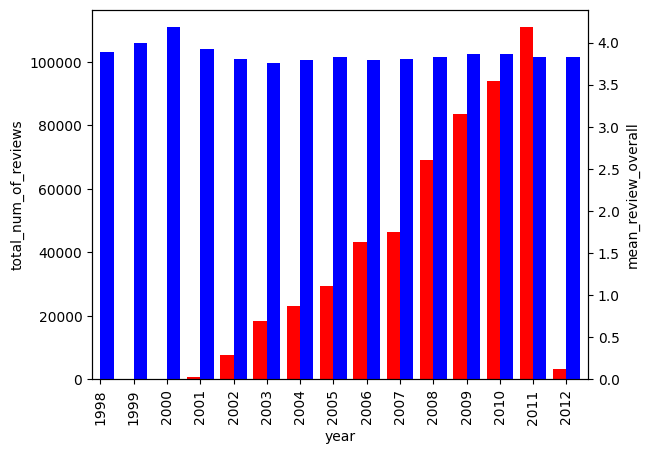

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.4

res.total_num_of_reviews.plot(kind = 'bar', color = 'red', ax = ax, width = width, position = 1)
res.mean_review_overall.plot(kind = 'bar', color = 'blue', ax = ax2, width = width, position = 0)

ax.set_ylabel('total_num_of_reviews')
ax2.set_ylabel('mean_review_overall')

### 3. Based on the users' ratings, which factors are important among taste, aroma, appearance and palette?

In [31]:
# correlation between review_overall and other factors

def correlation(col1:str, col2:str):
    if len(df[col1]) == len(df[col2]):

        sum_col1_col2 = sum((df[col1] - df[col1].mean()) - (df[col2] - df[col2].mean()))
        sum_col1_squared = sum(df[col1] - df[col1].mean()**2)
        sum_col2_squared = sum(df[col2] - df[col2].mean()**2)
        corr = sum_col1_col2 / np.sqrt(sum_col1_squared * sum_col2_squared)
        return corr

In [32]:
correlation('review_overall', 'review_palette')

2.236332955418899e-15

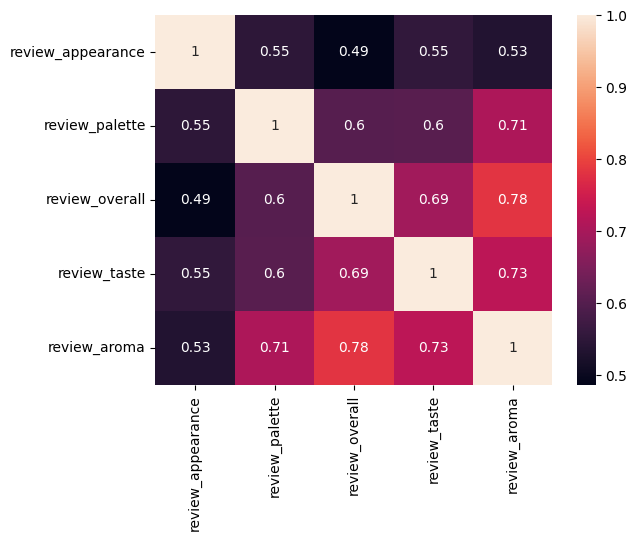

In [34]:
# pearson correlation

corr_df = df[['review_appearance', 'review_palette', 'review_overall', 'review_taste', 'review_aroma']]
corr_df.corr(method = 'pearson')
_ = heatmap(data=corr_df.corr(), annot=True)

### 4. If you were to recommend 3 beers to your friends based on this data, which ones would you recommend?

In [35]:
# num_of_users, review_overall

cnt_mean_by_beer_id = df.groupby(['beer_beerId'])['review_overall'].agg(['count', 'mean']).reset_index()
cnt_mean_by_beer_id.head()

,beer_beerId,count,mean
0,3,3,4.166667
1,4,10,3.700000
2,5,424,3.549528
3,6,877,3.706956
4,7,659,3.266313


In [36]:
cnt_mean_by_beer_id.describe()

,beer_beerId,count,mean
count,20200.000000,20200.000000,20200.000000
mean,39720.080990,26.181683,3.651862
std,22621.433795,123.799950,0.631129
min,3.000000,1.000000,1.000000
25%,19925.750000,1.000000,3.399774
50%,40712.500000,2.000000,3.750000
75%,59531.250000,7.000000,4.000000
max,77310.000000,3000.000000,5.000000


In [42]:
# cnt_mean_by_beer_id >= 200(threshold)

res = cnt_mean_by_beer_id[cnt_mean_by_beer_id['count']>=200].sort_values(by='mean', ascending = False).head(3)
top_3_id = [id for id in res['beer_beerId']]

dic = {}

df2 = df[['beer_beerId', 'beer_name', 'beer_ABV']]

for beer_id, sub in df2.groupby('beer_beerId'):
    if beer_id in top_3_id:
        beer_name = set([n for n in sub['beer_name']])
        beer_abv = set([a for a in sub['beer_ABV']])

        for name in beer_name:
            for abv in beer_abv:
                if name not in dic.keys():
                    dic[name] = abv
print(dic)

{'Heady Topper': 8.0, 'Founders CBS Imperial Stout': 10.6, 'Citra DIPA': 8.0}


### 5. Which beer style seems to be the favourite based on the reviews written by users? How does written reviews compare to overall review score for the beer style?

In [43]:
# review_df

review_df = df[['review_text']].reset_index()
review_df.head()

,index,review_text
0,0,A lot of foam. But a lot. In the smell some ba...
1,1,"Dark red color, light beige foam, average. In ..."
2,2,"Almost totally black. Beige foam, quite compac..."
3,3,"Golden yellow color. White, compact foam, quit..."
4,4,"According to the website, the style for the Ca..."


In [45]:
# vader

sia = SentimentIntensityAnalyzer()
res = {}
for i, row in tqdm(review_df.iterrows(), total = len(review_df)):
    text = row['review_text']
    idx = row['index']
    if type(text) == str:
        res[idx] = sia.polarity_scores(text)
    else:
        pass

  0%|          | 0/528870 [00:00<?, ?it/s]

In [48]:
vaders = pd.DataFrame(res).T

In [49]:
df_1 = df.reset_index()
df_2 = vaders.reset_index()

final = pd.merge(df_1, df_2, how = 'inner')
final.head()

,index,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year,ratings,neg,neu,pos,compound
0,0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823,2009,9.0,0.062,0.861,0.077,0.1879
1,1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097,2009,14.5,0.030,0.879,0.091,0.5927
2,2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604,2009,14.5,0.118,0.749,0.133,0.3021
3,3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145,2009,15.0,0.000,0.672,0.328,0.9772
4,4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206,2010,21.0,0.034,0.846,0.120,0.9538


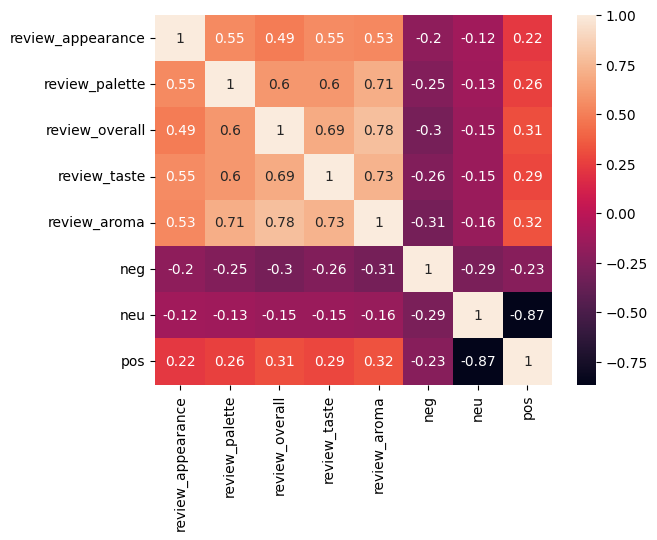

In [50]:
# correlation of sentiment(neg, neu, pos) & review_overall

corr_df = final[['review_appearance', 'review_palette', 'review_overall', 'review_taste', 'review_aroma', 'neg', 'neu', 'pos']]
corr_df.corr(method = 'pearson')
_ = heatmap(data=corr_df.corr(), annot=True)